<a href="https://colab.research.google.com/github/GouthamChandrappa46/MAE598/blob/main/mae598_designoptimization_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rocket Landing problem.

The following program optimizes the problem using a gradient descent algorithm with a fixed step size. The control inputs are determined via a neural network consisting of one hidden layer and an output layer. The program is given a single initial state of . In future iterations of this program, multiple initial states will be handled simultaneously.

[1] loss: 2.119


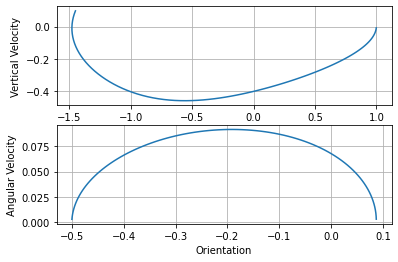

[2] loss: 0.864


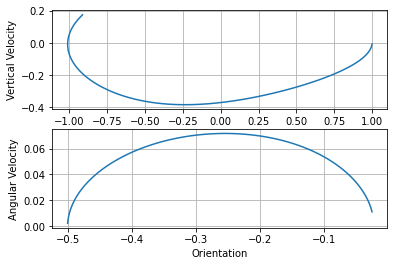

[3] loss: 0.436


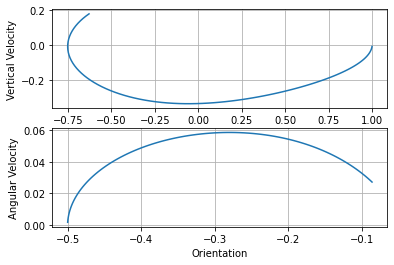

[4] loss: 0.246


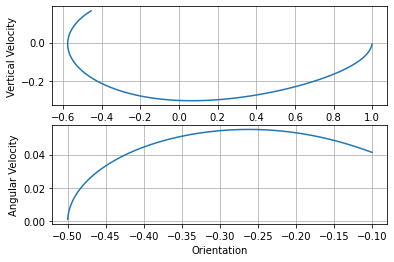

[5] loss: 0.134


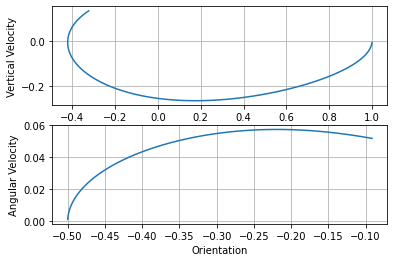

[6] loss: 0.064


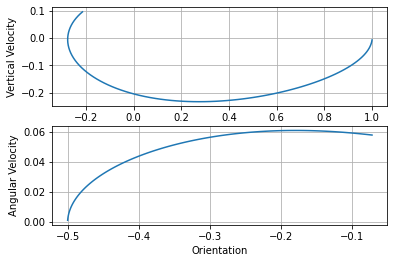

[7] loss: 0.029


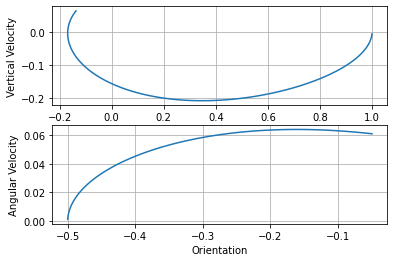

[8] loss: 0.016


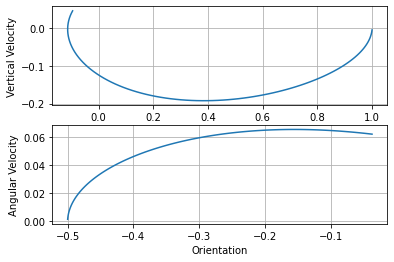

[9] loss: 0.011


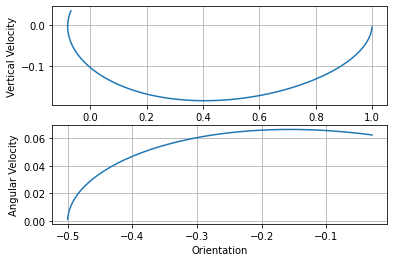

[10] loss: 0.008


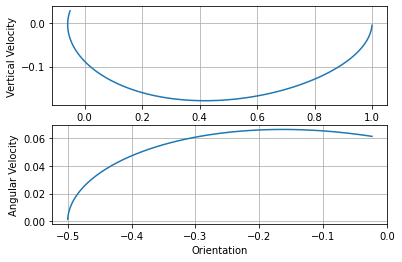

[11] loss: 0.006


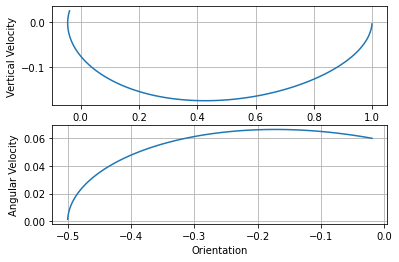

[12] loss: 0.005


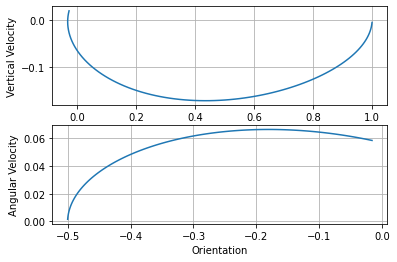

[13] loss: 0.004


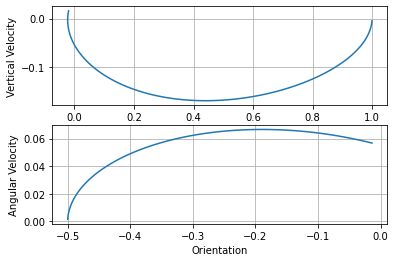

[14] loss: 0.003


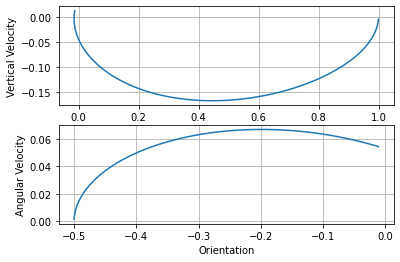

[15] loss: 0.003


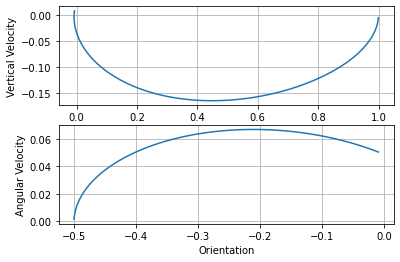

[16] loss: 0.002


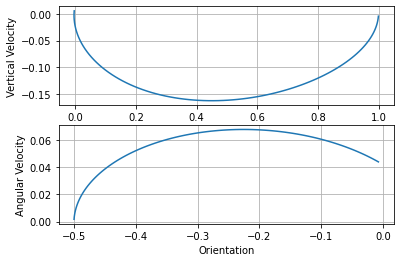

[17] loss: 0.001


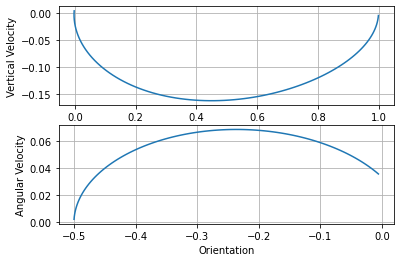

[18] loss: 0.001


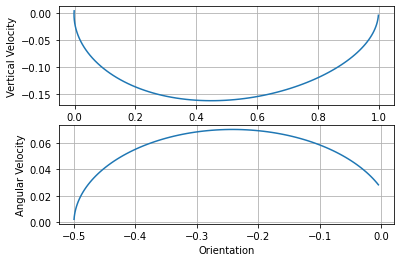

[19] loss: 0.001


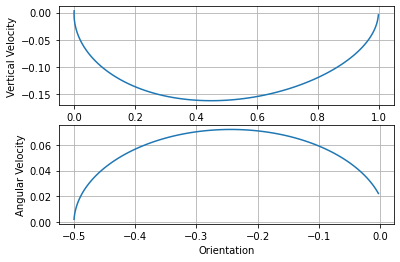

[20] loss: 0.000


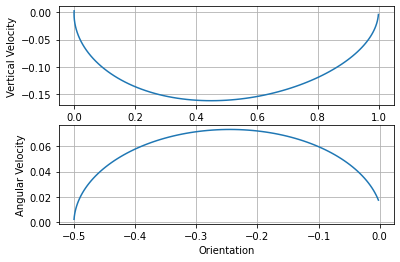

[21] loss: 0.000


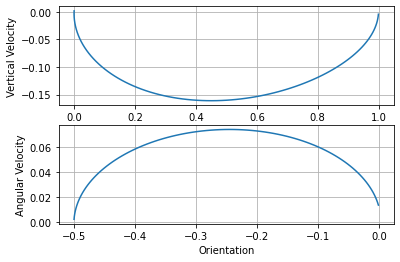

[22] loss: 0.000


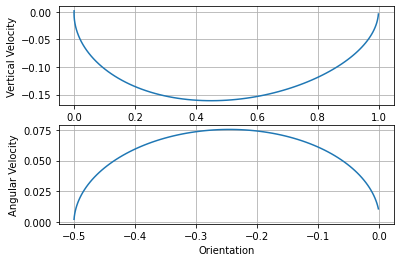

[23] loss: 0.000


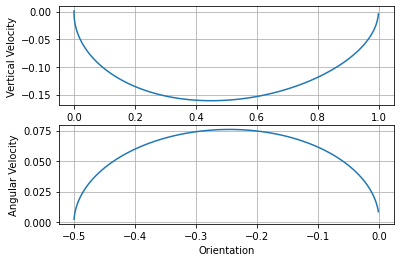

[24] loss: 0.000


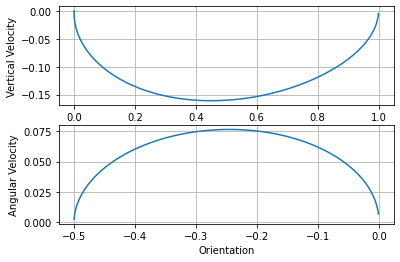

[25] loss: 0.000


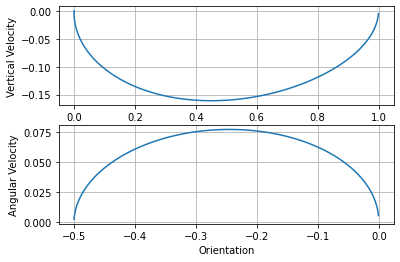

[26] loss: 0.000


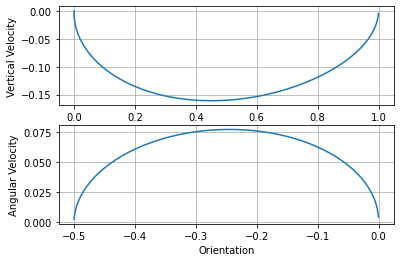

[27] loss: 0.000


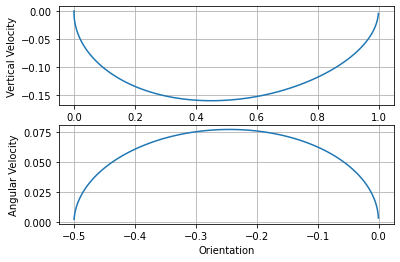

[28] loss: 0.000


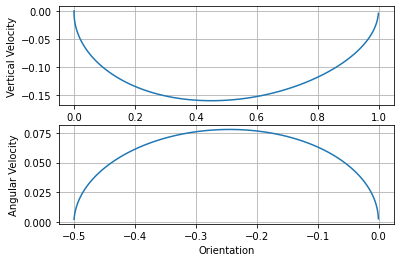

[29] loss: 0.000


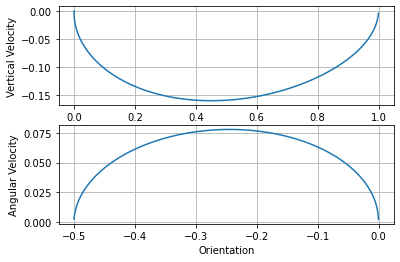

[30] loss: 0.000


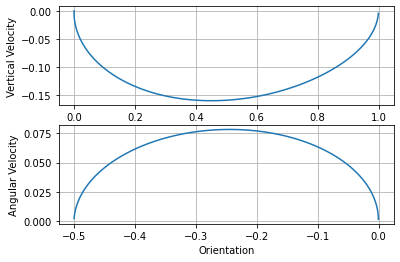

[31] loss: 0.000


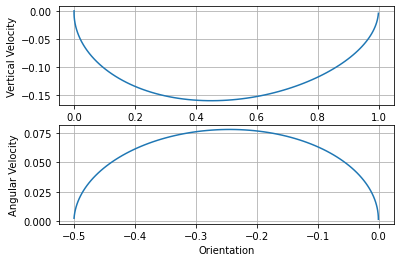

[32] loss: 0.000


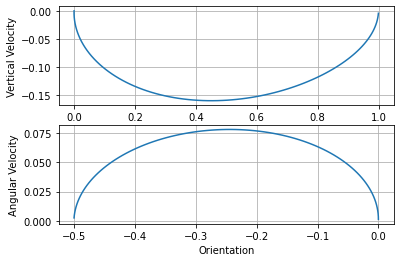

[33] loss: 0.000


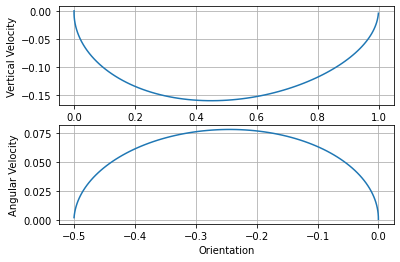

[34] loss: 0.000


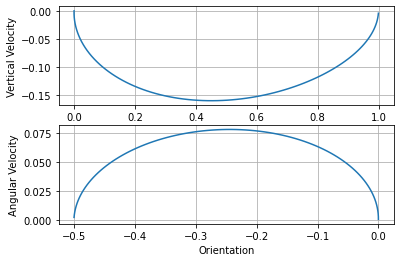

[35] loss: 0.000


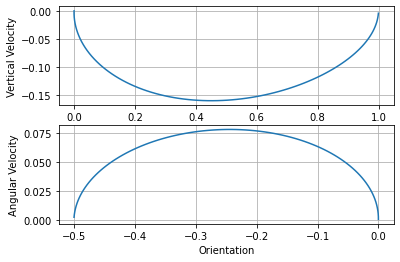

[36] loss: 0.000


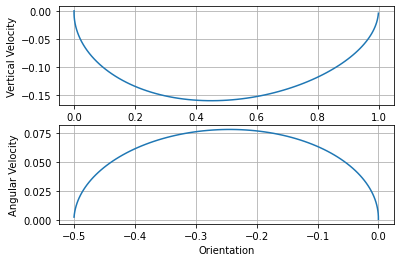

[37] loss: 0.000


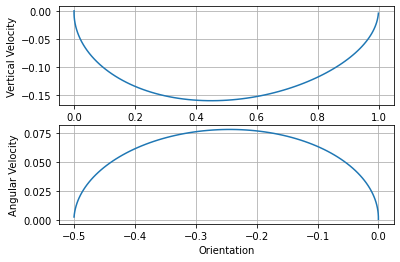

[38] loss: 0.000


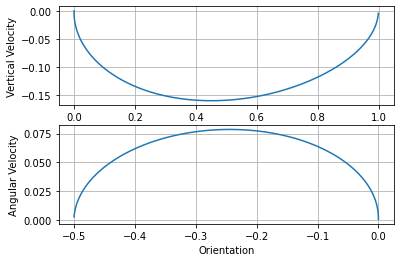

[39] loss: 0.000


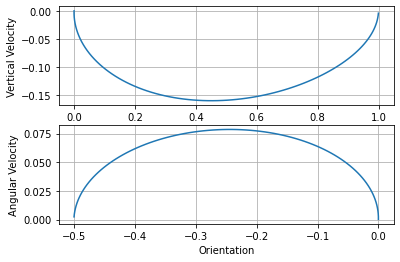

[40] loss: 0.000


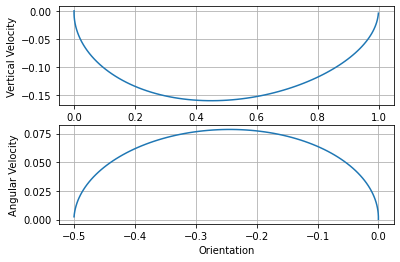

In [ ]:
import logging
from math import *
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# parameters for environment.

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # constant for gravity.
BOOST_ACCEL = 0.18  # thrust constant
DRAG_ACCEL = 0.04  # acceleration due to drag
ROT_ACCEL = 0.09  # angular acceleration




#  In this section we are defining the system dynamics and creating class called dynamics, controller,..
# for finding out the least loss in landing a rocket and we also tend to get the various graohs which shows the losses at various stages in the proecess of rocket landing,
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):
        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        state[2] = theta
        state[3] = theta_dot
        """

        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is
        # part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx.
        # This is allowed...
        del_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME, 0., 0.])

        #  implementing the formula for Drag calculation,
        # drag always Acts in the direction opposite to that of the velocity
        del_state_drag = DRAG_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.])

        # calculating the thrust,
         
        
        del_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., cos(state[2]), 0., 0.]) * action[0]

        # calculating the rotational thrust
        del_state_rot = ROT_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 1.]) * action[1]

        # updating the velocity,
        state = state + del_state + del_state_gravity + del_state_drag + del_state_rot

        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible.
        # Do not use element-wise operators as they are considered inplace.
        s_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        state = t.matmul(s_mat, state)

        return state


# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or
# deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Tanh()
        )

    # Forward updates action, which is passed to dynamics as control for next step
    def forward(self, state):
        action = (self.network(state))
        return action


# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of
# initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state
# trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1., 0., -0.5, 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()  # TODO: Why does requires_grad=False?

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2


# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider
# simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)
        self.loss = []

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()  # TODO: Why is this necessary?
            loss.backward()
            return loss

        self.optimizer.step(closure)  # TODO: Does this pass the gradient of loss to the optimizer, which performs GD?
        return closure()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.loss.append(loss.detach().numpy())
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        actions = np.array([self.simulation.action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        fig, axs = plt.subplots(2)
        x1 = data[:, 0]
        y1 = data[:, 1]
        x2 = data[:, 2]
        y2 = data[:, 3]
        axs[0].plot(x1, y1)
        axs[0].grid()
        axs[0].set_xlabel('Distance to land')
        axs[0].set_ylabel('velocity of the vertical position')
        axs[1].plot(x2, y2)
        axs[1].grid()
        axs[1].set_xlabel('Orientation of the rocket')
        axs[1].set_ylabel('Angular Velocity of the rocket')
        plt.show()

# lets run the code....

store_loss = []
epochs = 40
T = 100  # no of steps of time
dim_input = 4  # state space dimension
dim_hidden = 16  # latent dimension
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # controller
s = Simulation(c, d, T)  # simulation
o = Optimize(s)  # optimizer
o.train(epochs)  # to solve the optimization problem
store_loss.append(o.loss)

Analysis :
 It can be seen that the optimal solution is reached after 40 iterations of gradient descent because d(t)= v(t)= theta(t)=w(t is approximately equal to 0)


 A converge plot is provided below that demonstrates the reduction in loss per iteration untill the optimal solution is reached and the linear convergence rate of the gradient descent algorithm is approximately represented. The convergence rate appears to slow down after about 10 iterations but continues its initial rate after about 21 iterations.

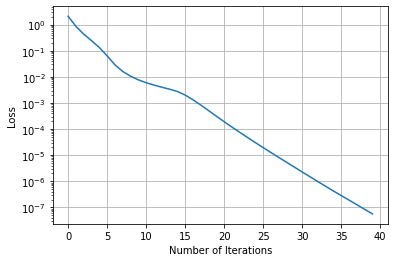

In [ ]:
plt.plot(range(epochs), store_loss[0])
plt.grid()
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()